NCAA DATA EXPLORATION & Z-SCORE ANALYSIS
Dataset shape: (721, 20)

Quadrant distribution:
  Quadrant 1: 100 teams (13.9%)
  Quadrant 2: 100 teams (13.9%)
  Quadrant 3: 200 teams (27.7%)
  Quadrant 4: 321 teams (44.5%)

Missing values detected:
Ranking    5
dtype: int64

Columns ranked by z-score variation between quadrants:
OpponentHomeWins: 0.7207
OpponentTotalWins: 0.6890
OpponentNeutralWins: 0.6796
HomeWins: 0.6725
TotalWins: 0.6213
AwayLosses: 0.5878
TotalLosses: 0.5758
NeutralWins: 0.5523
HomeLosses: 0.4933
OpponentNeutralLosses: 0.4675
OpponentAwayWins: 0.4406
AwayWins: 0.3140
OpponentAwayLosses: 0.3060
NeutralLosses: 0.2064
OpponentHomeLosses: 0.1509
OpponentTotalLosses: 0.1436

Creating distribution plots for top 10 features...

Creating feature variation plot...

Creating boxplots for top 5 features...

Creating heatmap for top 10 features...

Analysis complete! Created 4 visualization files:
1. zscore_distributions.png - KDE plots of z-score distributions by quadrant
2. featu

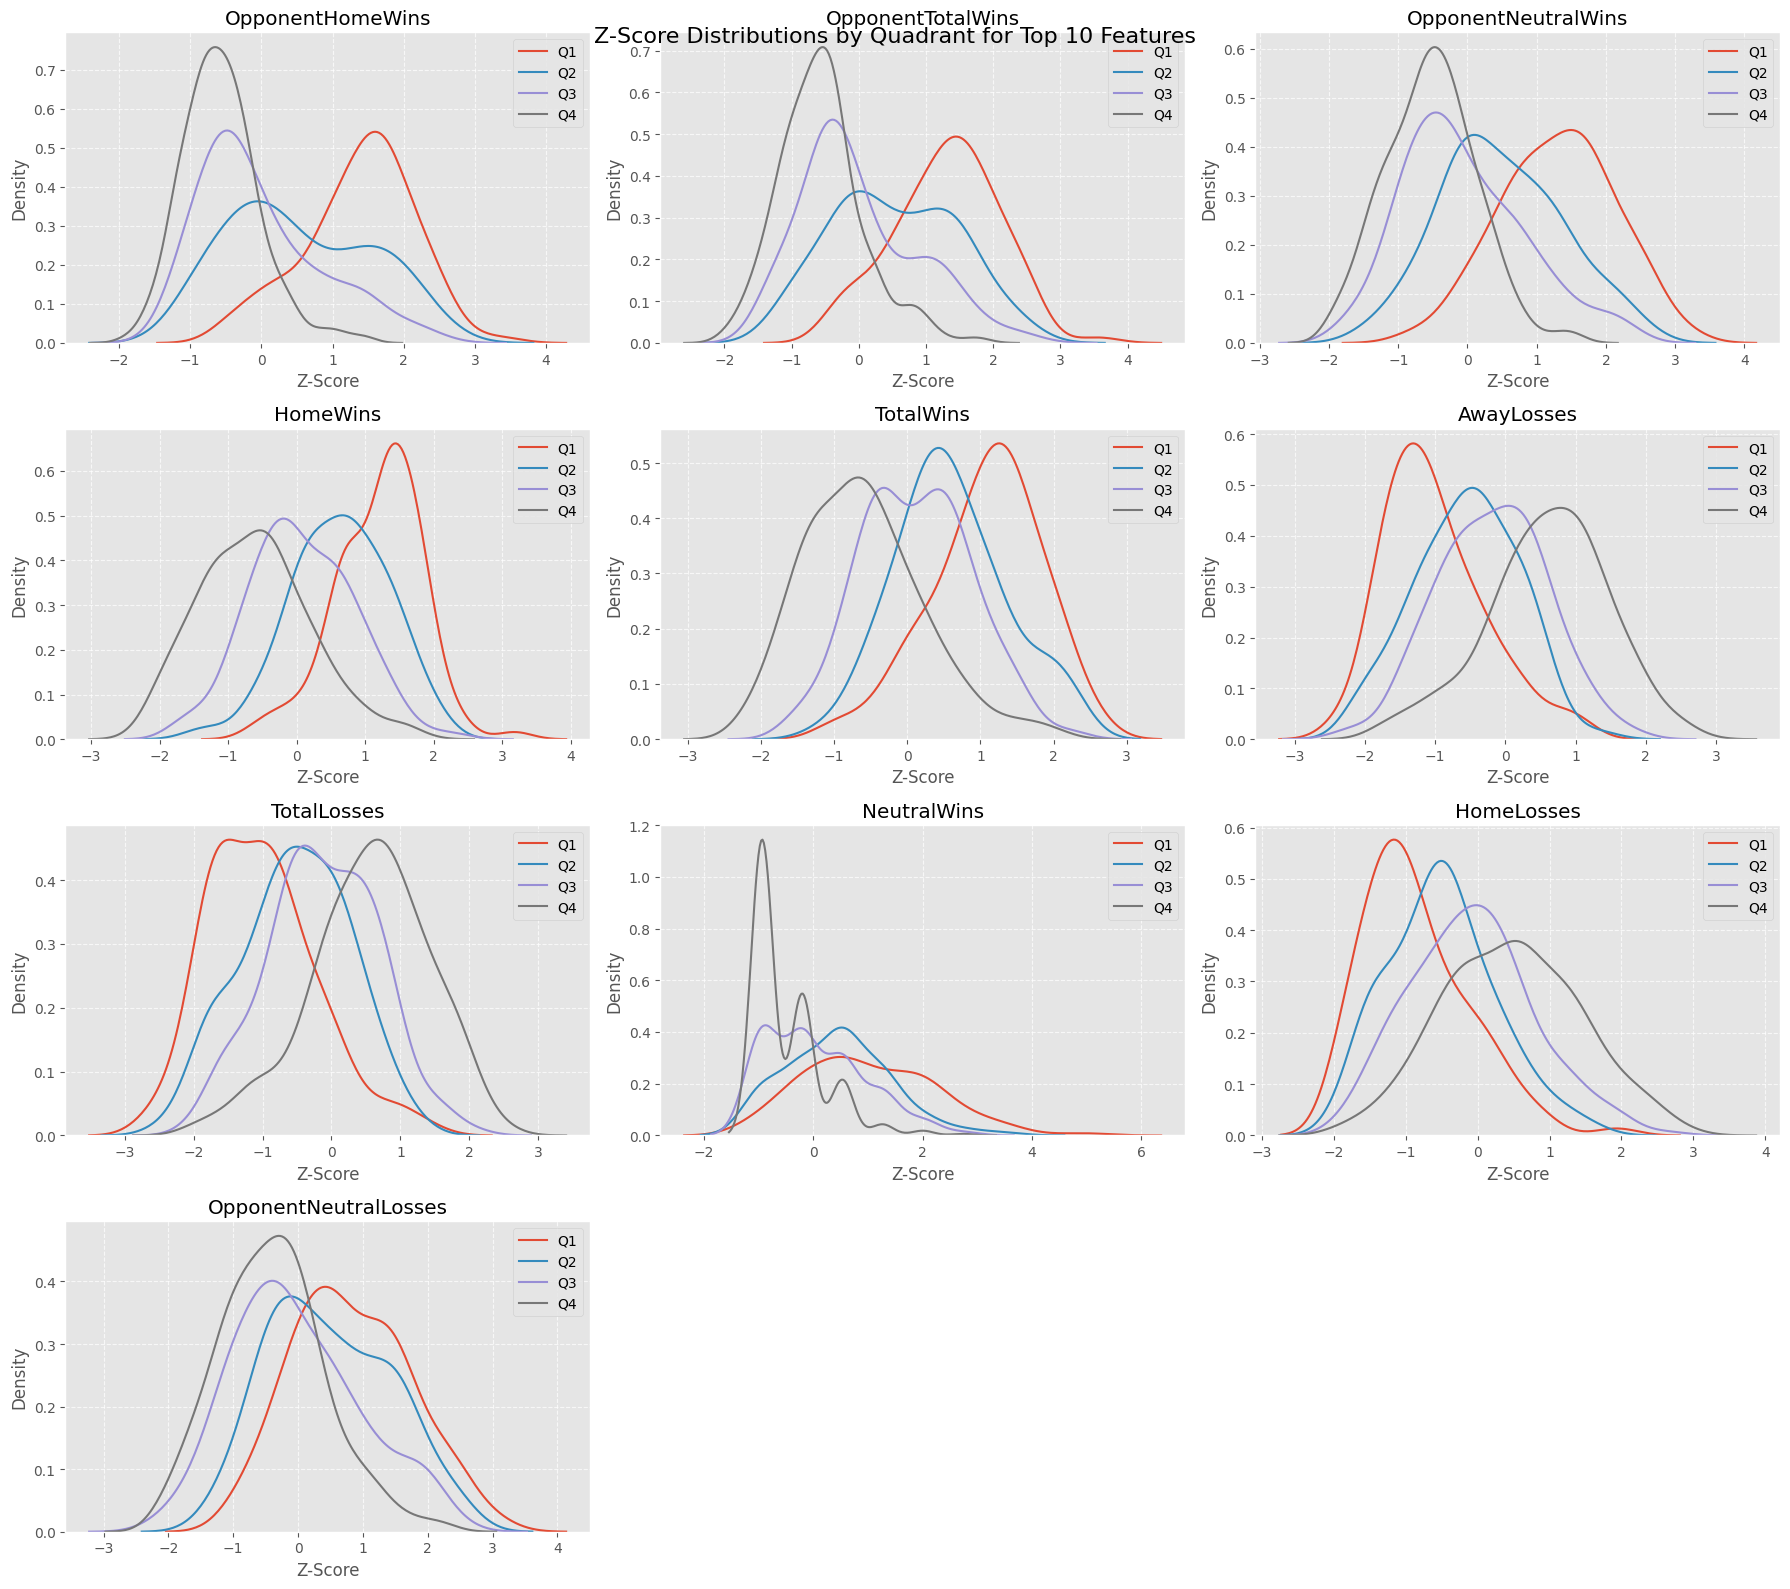

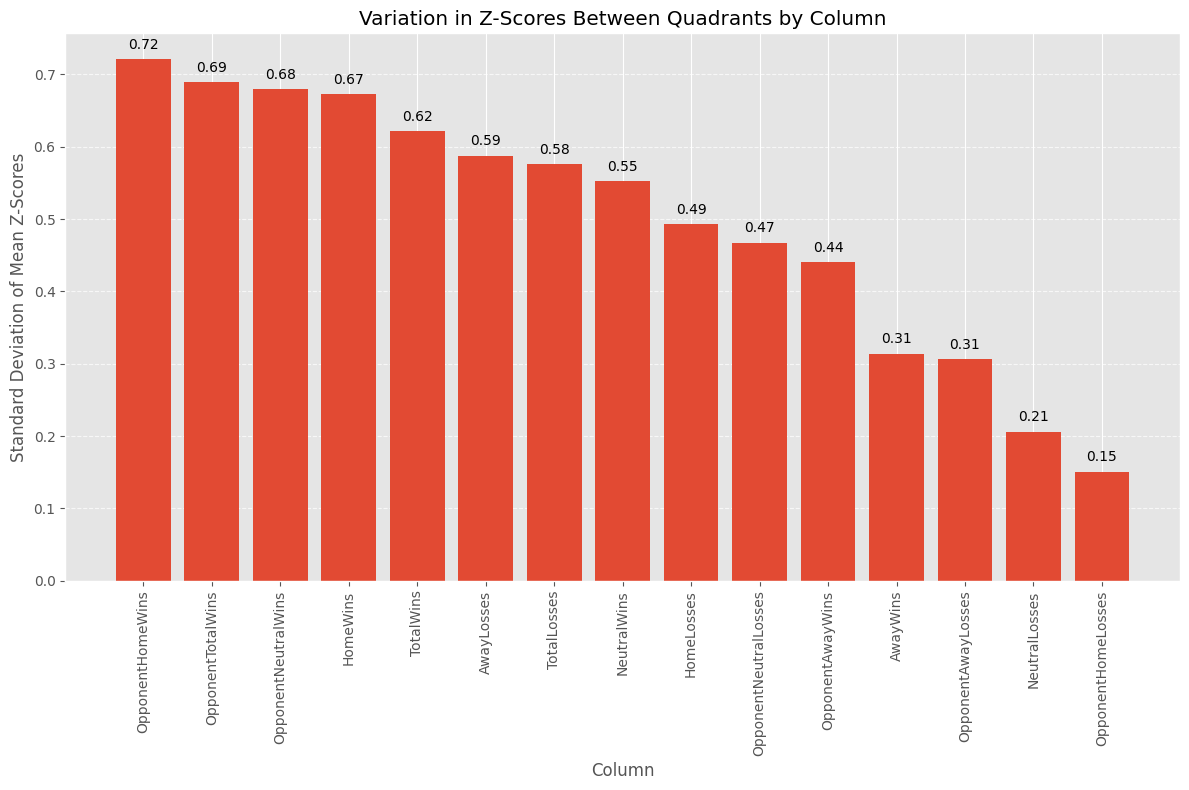

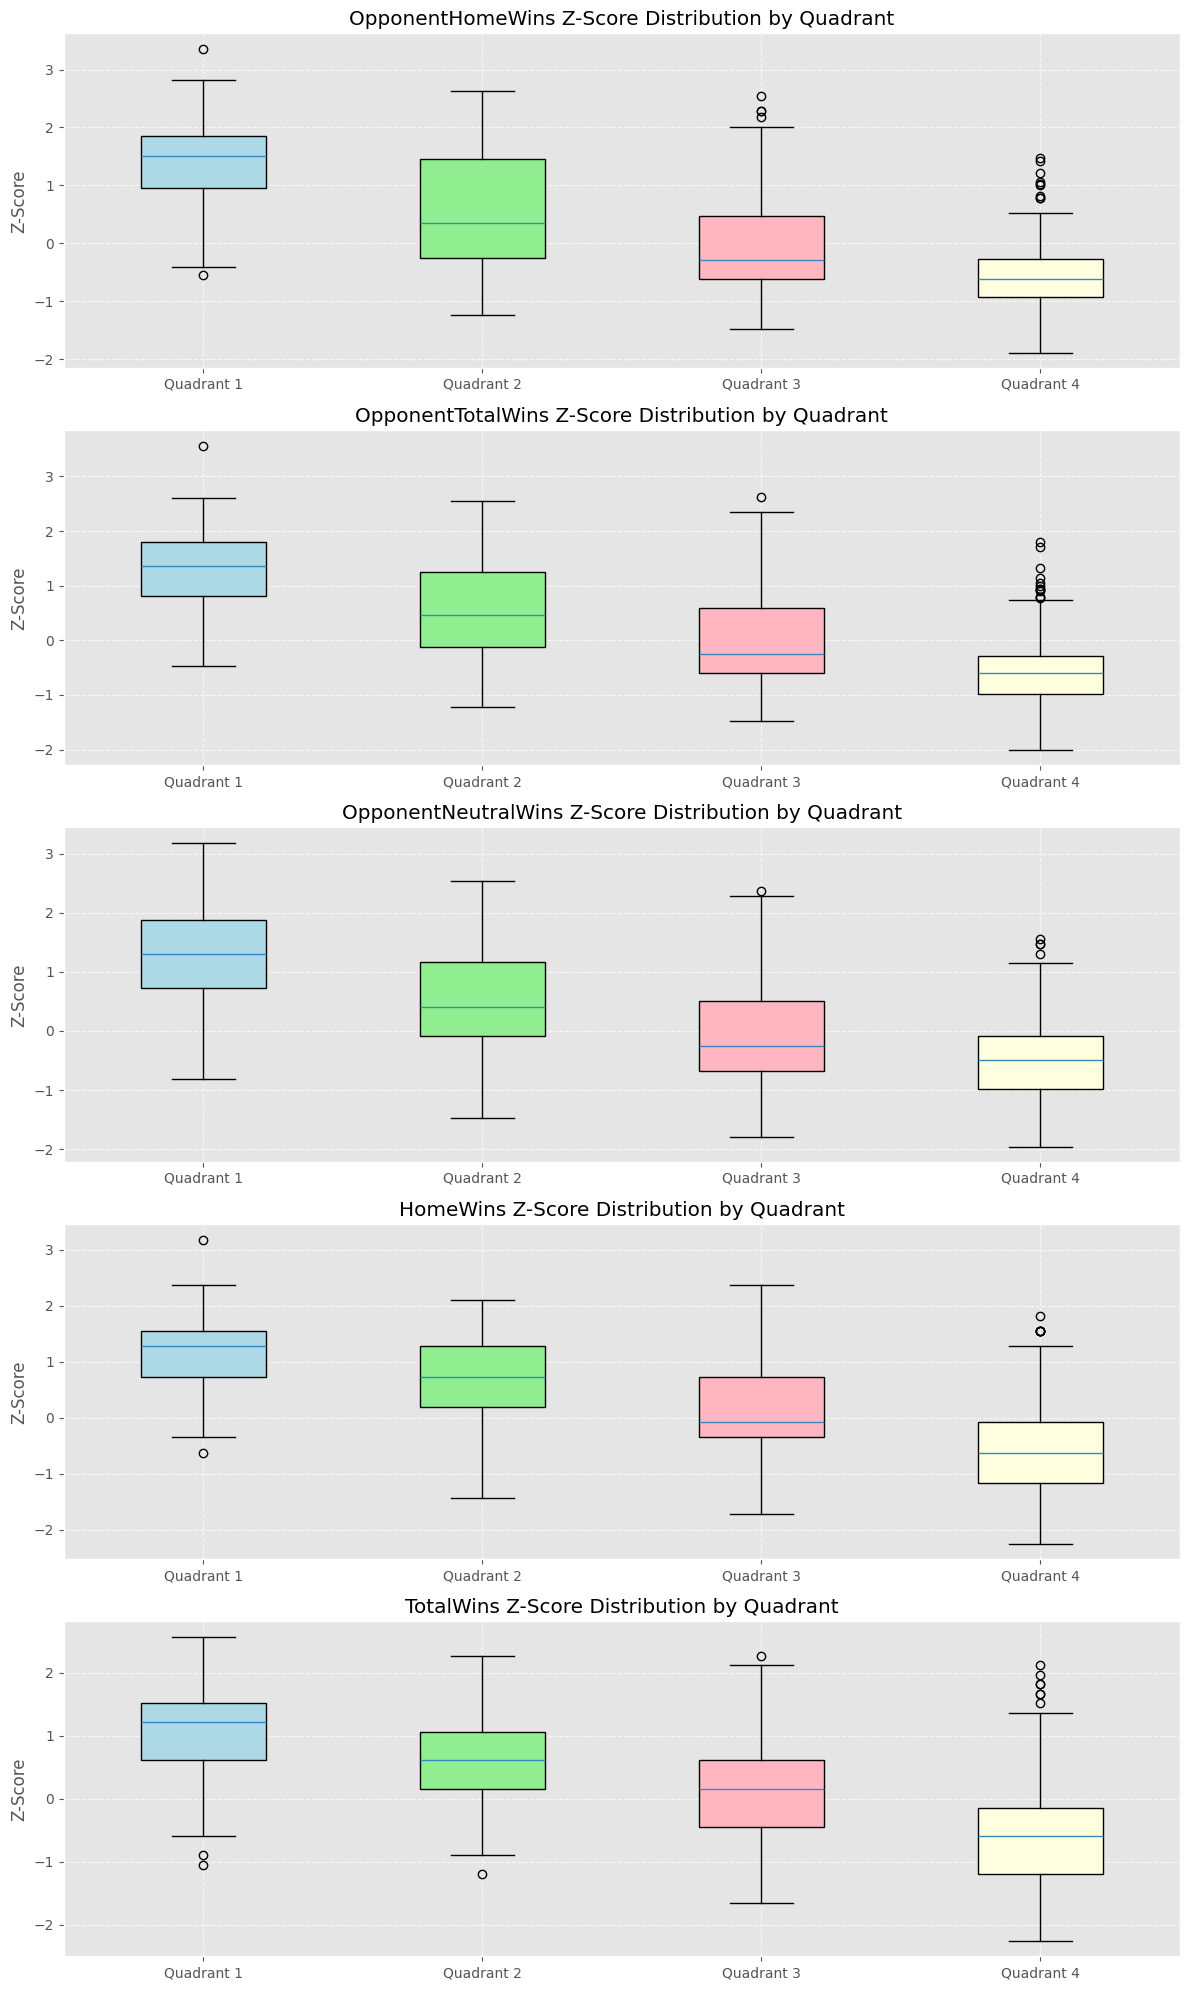

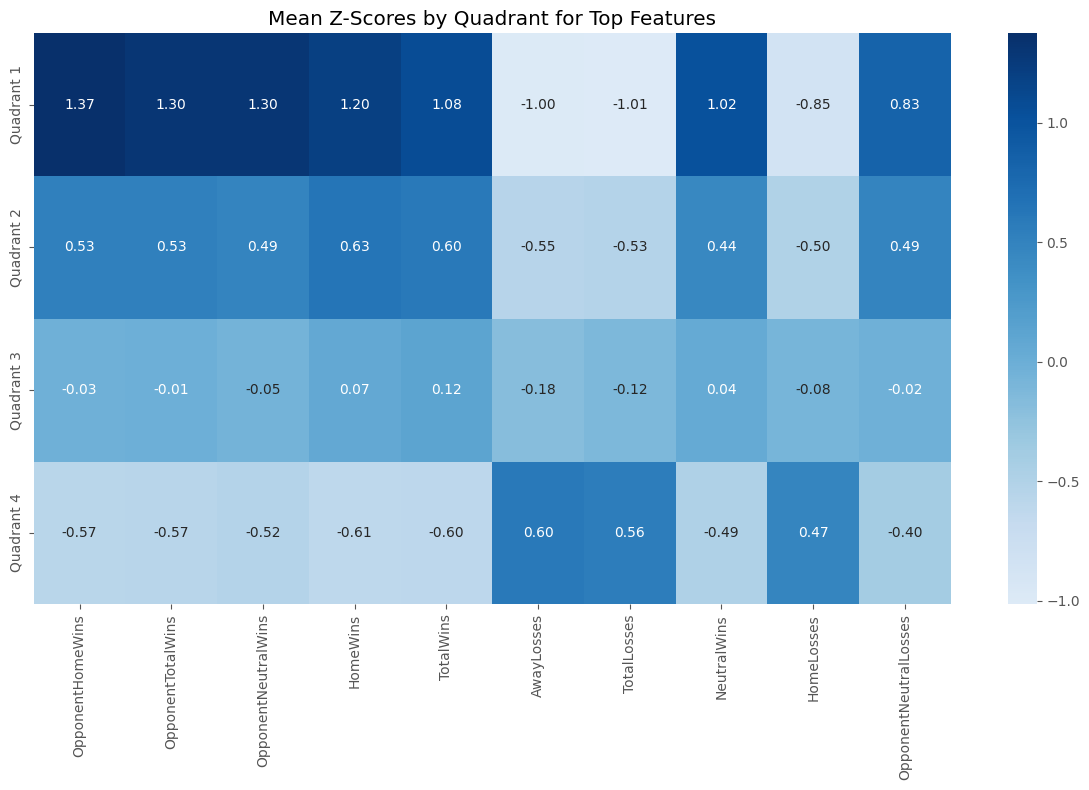

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings
plt.style.use('ggplot')  # Use a nicer style for plots

# Load the data
df = pd.read_csv('ncaa_data_W_all.csv')

# Basic data exploration
print("=" * 50)
print("NCAA DATA EXPLORATION & Z-SCORE ANALYSIS")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"\nQuadrant distribution:")
quad_dist = df['Quadrant'].value_counts().sort_index()
for q, count in quad_dist.items():
    print(f"  Quadrant {q}: {count} teams ({count/len(df)*100:.1f}%)")

# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values detected:")
    print(missing[missing > 0])
else:
    print("\nNo missing values detected in the dataset.")

# Define columns to analyze (exclude TeamID, TeamName, and Ranking)
exclude_cols = ['TeamID', 'TeamName', 'Ranking']
cols_to_analyze = [col for col in df.columns if col not in exclude_cols]

# Calculate z-scores for each column (standardize the data)
# Note: We'll keep the original Quadrant column as is for grouping
z_score_df = df.copy()
for col in cols_to_analyze:
    if col != 'Quadrant':  # Don't standardize the Quadrant column
        z_score_df[col] = stats.zscore(df[col], nan_policy='omit')

# Create a function to plot z-score distributions by quadrant
def plot_zscore_distributions(df, columns, quadrants=None):
    """Plot z-score distributions for specified columns by quadrant."""
    if quadrants is None:
        quadrants = sorted(df['Quadrant'].unique())
    
    # Calculate the grid dimensions
    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    # Create the plot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()
    
    # Clear any unused subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])
    
    # Create plots for each column
    for i, col in enumerate(columns):
        if col == 'Quadrant':
            continue
            
        ax = axes[i]
        for q in quadrants:
            q_data = df[df['Quadrant'] == q][col].dropna()
            if not q_data.empty:
                sns.kdeplot(q_data, ax=ax, label=f'Q{q}')
        
        ax.set_title(f'{col}')
        ax.set_xlabel('Z-Score')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig

# Calculate the variance of mean z-scores across quadrants for each column
# This will help identify which columns differ most between quadrants
def calculate_variation_between_quadrants(df):
    quadrants = sorted(df['Quadrant'].unique())
    variation = {}
    
    for col in cols_to_analyze:
        if col == 'Quadrant':
            continue
            
        # Calculate mean z-score for each quadrant
        quadrant_means = []
        for q in quadrants:
            q_mean = df[df['Quadrant'] == q][col].mean()
            quadrant_means.append(q_mean)
        
        # Calculate standard deviation of these means across quadrants
        variation[col] = np.std(quadrant_means)
    
    # Sort columns by variation (highest first)
    sorted_cols = sorted(variation.items(), key=lambda x: x[1], reverse=True)
    return sorted_cols

# Calculate variation between quadrants
variation_by_col = calculate_variation_between_quadrants(z_score_df)
print("\nColumns ranked by z-score variation between quadrants:")
for col, var in variation_by_col:
    print(f"{col}: {var:.4f}")

# Create a bar chart showing the variation in z-scores by column
def plot_variation_by_column(variation_data):
    """Plot the variation in z-scores by column."""
    cols = [x[0] for x in variation_data]
    vars = [x[1] for x in variation_data]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(cols, vars)
    
    # Add data labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                 height + 0.01,
                 f'{height:.2f}',
                 ha='center', va='bottom', rotation=0)
    
    plt.title('Variation in Z-Scores Between Quadrants by Column')
    plt.xlabel('Column')
    plt.ylabel('Standard Deviation of Mean Z-Scores')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    return plt.gcf()

# Create visualizations
top_10_cols = [x[0] for x in variation_by_col[:10]]
if 'Quadrant' in top_10_cols:
    top_10_cols.remove('Quadrant')

# Plot z-score distributions for top columns
print("\nCreating distribution plots for top 10 features...")
dist_fig = plot_zscore_distributions(z_score_df, top_10_cols)
dist_fig.suptitle('Z-Score Distributions by Quadrant for Top 10 Features', fontsize=16)
plt.savefig('zscore_distributions.png', dpi=300, bbox_inches='tight')

# Plot variation by column
print("\nCreating feature variation plot...")
var_fig = plot_variation_by_column(variation_by_col[:15])  # Show top 15 for better visibility
plt.savefig('feature_variation.png', dpi=300, bbox_inches='tight')

# Create more detailed analysis with box plots for the top 5 features
def plot_boxplots_by_quadrant(df, columns):
    """Create box plots for each column by quadrant."""
    quadrants = sorted(df['Quadrant'].unique())
    
    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 4*len(columns)))
    if len(columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(columns):
        ax = axes[i]
        # Prepare data for boxplot
        data = [df[df['Quadrant'] == q][col].dropna() for q in quadrants]
        
        # Create boxplot
        bp = ax.boxplot(data, patch_artist=True, labels=[f'Quadrant {q}' for q in quadrants])
        
        # Set colors for each box
        colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors[:len(quadrants)]):
            patch.set_facecolor(color)
        
        ax.set_title(f'{col} Z-Score Distribution by Quadrant')
        ax.set_ylabel('Z-Score')
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig

# Create boxplots for top 5 features
top_5_cols = [x[0] for x in variation_by_col[:5]]
if 'Quadrant' in top_5_cols:
    top_5_cols.remove('Quadrant')

print("\nCreating boxplots for top 5 features...")
box_fig = plot_boxplots_by_quadrant(z_score_df, top_5_cols)
plt.savefig('top5_boxplots.png', dpi=300, bbox_inches='tight')

# Create a heatmap showing mean z-scores by quadrant for top features
def create_zscore_heatmap(df, columns):
    """Create a heatmap of mean z-scores by quadrant for top features."""
    quadrants = sorted(df['Quadrant'].unique())
    
    # Calculate mean z-score for each quadrant and column
    mean_zscores = {}
    for col in columns:
        mean_zscores[col] = []
        for q in quadrants:
            mean_zscores[col].append(df[df['Quadrant'] == q][col].mean())
    
    # Convert to DataFrame for heatmap
    heatmap_df = pd.DataFrame(mean_zscores, index=[f'Quadrant {q}' for q in quadrants])
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_df, annot=True, cmap='Blues', center=0, fmt='.2f')
    plt.title('Mean Z-Scores by Quadrant for Top Features')
    plt.tight_layout()
    return plt.gcf()

# Create heatmap for top 10 features
print("\nCreating heatmap for top 10 features...")
heat_fig = create_zscore_heatmap(z_score_df, top_10_cols)
plt.savefig('zscore_heatmap.png', dpi=300, bbox_inches='tight')

print("\nAnalysis complete! Created 4 visualization files:")
print("1. zscore_distributions.png - KDE plots of z-score distributions by quadrant")
print("2. feature_variation.png - Bar chart of feature variation between quadrants")
print("3. top5_boxplots.png - Box plots of z-scores by quadrant for top 5 features")
print("4. zscore_heatmap.png - Heatmap of mean z-scores by quadrant for top features")

# Display the top features for feature selection
print("\nRecommended features for selection (highest variation between quadrants):")
for i, (col, var) in enumerate(variation_by_col[:10], 1):
    if col != 'Quadrant':
        print(f"{i}. {col} (variation: {var:.4f})")